Datos cargados exitosamente desde 'pentagon_training_data_proporcional.csv'. Número total de muestras: 200000
Primeras filas de los datos cargados:
   x_centroid  y_centroid fault_zone
0   -0.671631   25.583296         PD
1   -0.040816   25.907778         PD
2   -0.613014   25.543705         PD
3   -0.443277   27.637874         PD
4   -0.298373   25.884183         PD

Distribución de clases en el conjunto de datos completo:
fault_zone
S       23.2015
D1      21.0930
D2      18.7405
T1-O    15.0650
T3-H    10.6010
T2-C     8.6765
T3-C     1.5475
T1-C     0.7650
PD       0.2230
T2-O     0.0870
Name: proportion, dtype: float64

Clases encontradas y su codificación numérica:
{0: 'D1', 1: 'D2', 2: 'PD', 3: 'S', 4: 'T1-C', 5: 'T1-O', 6: 'T2-C', 7: 'T2-O', 8: 'T3-C', 9: 'T3-H'}

Tamaño del conjunto de entrenamiento: 160000 muestras (80.00%)
Tamaño del conjunto de prueba: 40000 muestras (20.00%)

Entrenando el modelo Random Forest... (Esto podría tardar unos minutos)
Modelo entrenado exitosame

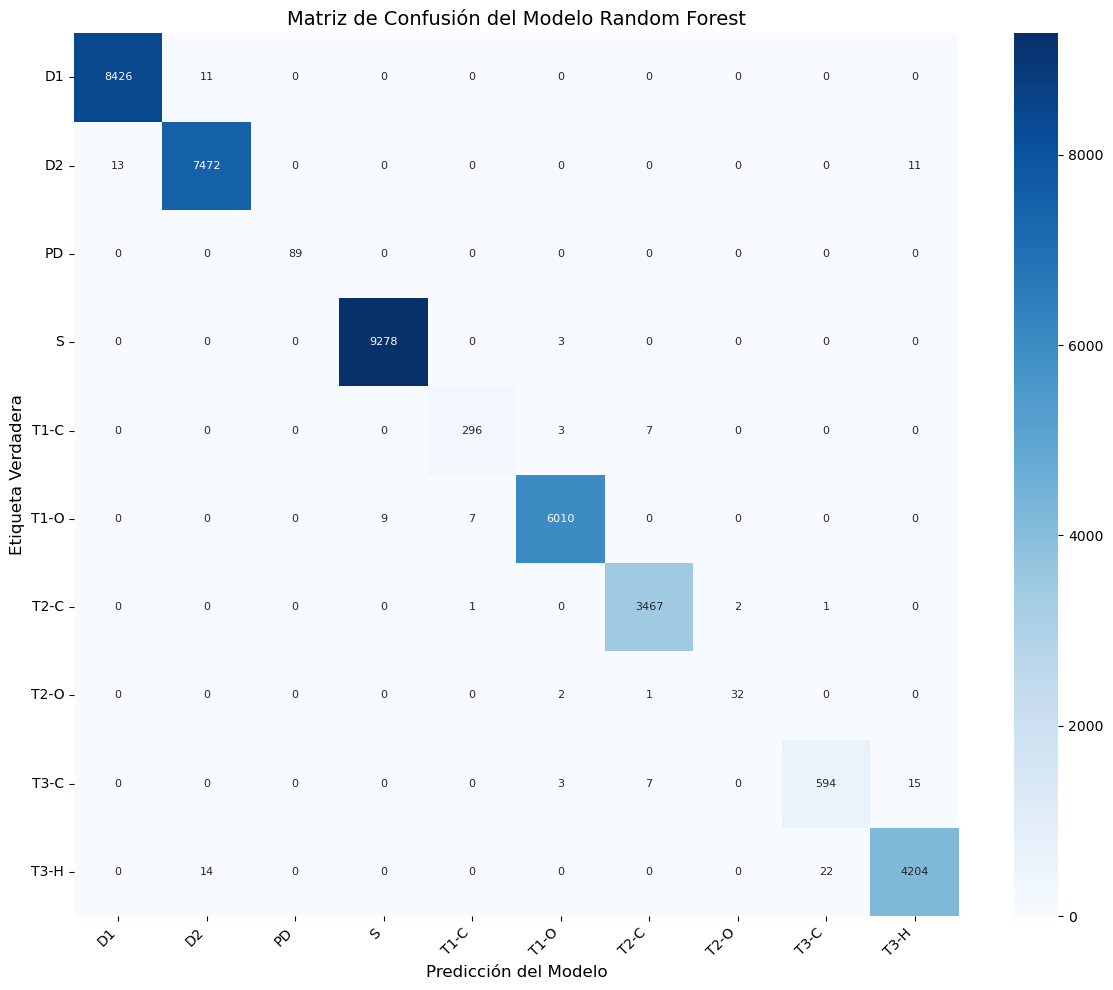


Modelo y LabelEncoder guardados exitosamente.
Archivos: 'modelo_pentagono_rf.pkl', 'label_encoder_pentagono.pkl'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # Para guardar el modelo y el LabelEncoder

# --- 1. Cargar los Datos Generados ---
# Asegúrate de que el archivo CSV se haya guardado correctamente desde el script anterior
csv_file_path = "pentagon_training_data_proporcional.csv"
df_data = None # Inicializar df_data

try:
    df_data = pd.read_csv(csv_file_path)
    print(f"Datos cargados exitosamente desde '{csv_file_path}'. Número total de muestras: {len(df_data)}")
    print("Primeras filas de los datos cargados:")
    print(df_data.head())
    print("\nDistribución de clases en el conjunto de datos completo:")
    print(df_data['fault_zone'].value_counts(normalize=True) * 100)
except FileNotFoundError:
    print(f"Error: El archivo '{csv_file_path}' no fue encontrado.")
    print("Por favor, asegúrate de ejecutar primero el script de generación de datos y guardar el CSV.")
except pd.errors.EmptyDataError:
    print(f"Error: El archivo '{csv_file_path}' está vacío.")
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")

# Continuar solo si los datos se cargaron correctamente y no están vacíos
if df_data is not None and not df_data.empty:
    # --- 2. Separar Características (X) y Etiqueta (y) ---
    X = df_data[['x_centroid', 'y_centroid']]
    y_text_labels = df_data['fault_zone']

    # --- 3. Codificar las Etiquetas de Texto a Números ---
    label_encoder = LabelEncoder()
    y_numerical_labels = label_encoder.fit_transform(y_text_labels)

    print("\nClases encontradas y su codificación numérica:")
    class_mapping = {i: class_name for i, class_name in enumerate(label_encoder.classes_)}
    print(class_mapping) # Imprime el mapeo para referencia

    # --- 4. Dividir en Conjuntos de Entrenamiento y Prueba ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_numerical_labels,
        test_size=0.2, # 20% para prueba
        random_state=42, # Para reproducibilidad
        stratify=y_numerical_labels # Importante para mantener proporción de clases
    )

    print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras ({len(X_train)/len(X)*100:.2f}%)")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras ({len(X_test)/len(X)*100:.2f}%)")

    # --- 5. Seleccionar, Entrenar y Evaluar un Modelo (Random Forest) ---
    # Verificar si X_train existe antes de usarlo (como una doble comprobación)
    if 'X_train' in locals() and 'y_train' in locals():
        model = RandomForestClassifier(n_estimators=100,
                                       random_state=42,
                                       n_jobs=-1,
                                       class_weight='balanced_subsample')

        print("\nEntrenando el modelo Random Forest... (Esto podría tardar unos minutos)")
        model.fit(X_train, y_train)
        print("Modelo entrenado exitosamente.")

        # Hacer predicciones en el conjunto de prueba
        print("\nHaciendo predicciones en el conjunto de prueba...")
        y_pred = model.predict(X_test)

        # Evaluar el modelo
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nExactitud (Accuracy) del modelo en el conjunto de prueba: {accuracy:.4f}")

        print("\nReporte de Clasificación Detallado:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4))

        print("\nMatriz de Confusión:")
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_,
                    annot_kws={"size": 8})
        plt.xlabel("Predicción del Modelo", fontsize=12)
        plt.ylabel("Etiqueta Verdadera", fontsize=12)
        plt.title("Matriz de Confusión del Modelo Random Forest", fontsize=14)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # --- Guardar el modelo entrenado y el LabelEncoder ---
        try:
            joblib.dump(model, 'modelo_pentagono_rf.pkl')
            joblib.dump(label_encoder, 'label_encoder_pentagono.pkl')
            print("\nModelo y LabelEncoder guardados exitosamente.")
            print("Archivos: 'modelo_pentagono_rf.pkl', 'label_encoder_pentagono.pkl'")
        except Exception as e:
            print(f"Error al guardar el modelo o LabelEncoder: {e}")

    else:
        print("Error: Las variables X_train o y_train no están definidas. Asegúrate de ejecutar las celdas de preparación de datos.")
else:
    print("\nNo se pudieron cargar los datos o el DataFrame está vacío. El entrenamiento del modelo no continuará.")

